# SVC kernels: polynomial degree 2 vs rbf

In [15]:
import pandas as pd
from sklearn.model_selection import cross_val_predict, StratifiedKFold
from sklearn.svm import LinearSVC, SVC
from sklearn.metrics import classification_report, ConfusionMatrixDisplay, confusion_matrix
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from time import time
import numpy as np

In [16]:
# get features and labels
data = pd.read_pickle('pifsc_embeddings2.pickle')
features = dict(data)
data = pd.read_pickle('pifsc_embeddings.pkl')
features.update(data)

cols = ["species","image","distinctiveness","quality"]
labels1 = pd.read_csv('pifsc_labels_detail.csv')[cols]

cols = ["species","filename","distinctiveness","quality"]
labels2 = pd.read_csv('pifsc_labels2.csv')[cols]
labels2.columns = ["species","image","distinctiveness","quality"]

labels = pd.concat([labels1, labels2]).reset_index(drop=True)

In [17]:
# clean labels
is_na = labels.distinctiveness.isna()
labels = labels.loc[~is_na]
labels = labels.drop_duplicates(subset='image', keep='first')
# labels.reset_index(drop=False, inplace=True)

# clean features
imgs = labels.image.tolist()
features = {k: v for k, v in features.items() if k in imgs}
assert len(features) == len(labels)

In [18]:
# get data, split
Y = labels.distinctiveness
X = np.array([features[i] for i in labels.image])
# species = labels.species.astype('category').cat.codes
# X = np.insert(X, 0, species, axis=1)
sc = StandardScaler()
X = sc.fit_transform(X)
# X_train, X_test, Y_train, Y_test = train_test_split(X, Y, random_state=42, stratify=Y)

In [19]:
# train Logistic regression
classifiers = [
    SVC(class_weight='balanced', random_state=42, kernel='rbf'),
    SVC(class_weight='balanced', random_state=42, kernel='poly', degree=2)
    ]
cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=35)
# for clf in classifiers:
#     # print(clf.kernel)
#     clf.fit(X_train, Y_train)

In [20]:
preds = []
for clf in classifiers:
    pred = cross_val_predict(clf, X, Y, n_jobs=-1, cv=cv)
    preds.append(pred)
    print(clf.kernel.center(53, '-'))
    print(classification_report(Y, pred))

-------------------------rbf-------------------------
              precision    recall  f1-score   support

         1.0       0.88      0.90      0.89      1152
         2.0       0.93      0.94      0.94      2343
         3.0       0.70      0.36      0.48        44
         4.0       0.94      0.43      0.59        37

    accuracy                           0.91      3576
   macro avg       0.86      0.66      0.72      3576
weighted avg       0.91      0.91      0.91      3576

-------------------------poly------------------------
              precision    recall  f1-score   support

         1.0       0.92      0.89      0.90      1152
         2.0       0.93      0.96      0.94      2343
         3.0       0.65      0.34      0.45        44
         4.0       0.93      0.38      0.54        37

    accuracy                           0.92      3576
   macro avg       0.86      0.64      0.71      3576
weighted avg       0.92      0.92      0.92      3576



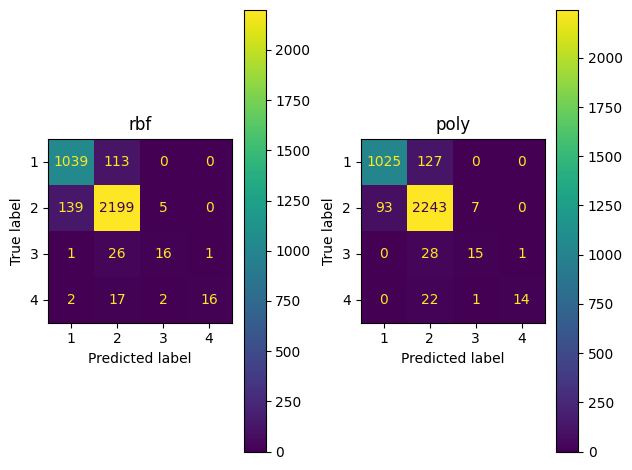

In [21]:
# results
fig, axes = plt.subplots(1, 2)
for i, (clf, ax) in enumerate(zip(classifiers, axes.flatten())):
    cm = confusion_matrix(Y, preds[i])
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[1,2,3,4])
    disp.plot(ax=ax)
    ax.title.set_text(clf.kernel)
plt.tight_layout()